In [116]:
!pip install catboost -q

In [117]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import os

In [118]:
df = pd.read_feather('/kaggle/input/rlthack-data/merged_features_v2.feather')
df['termination'] = df['termination'].fillna(False)
df['capital_size'] = df['capital_size'].fillna(0)
df.capital_size = df.capital_size.apply(lambda x: 0 if isinstance(x, str) else x) 
df['has_filial'] = df['has_filial'].astype(bool)
df['is_entity_person'] = df['is_entity_person'].fillna(-1).astype(int)

In [119]:
cat_features = ['okved_basic_code']

In [120]:
df['rnp'] = df['rnp_count'].isna().astype(int)
df = df.drop(columns=['rnp_count'])

df['real_rnp'] = False
df.loc[df['rnp'] == 0, 'real_rnp'] = True

# df.loc[df['is_termination'] > 2, 'rnp'] = 0
df['rnp'].value_counts(), df['real_rnp'].value_counts()

(1    197107
 0      2865
 Name: rnp, dtype: int64,
 False    197107
 True       2865
 Name: real_rnp, dtype: int64)

In [123]:
df = df.fillna(0)

In [131]:
def get_fold(fold):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0xFACED)

    for f, (train_idxs, val_idxs) in enumerate(kfold.split(df, df['real_rnp'])):
        if f == fold:
            df_train = df.iloc[train_idxs]
            df_val = df.iloc[val_idxs]
            
    return df_train, df_val

In [ ]:
from catboost import CatBoostClassifier, Pool, CatBoostRanker
from copy import deepcopy

In [126]:
def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=test):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    model = CatBoostClassifier(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=True)
    
    return model

In [127]:
default_parameters = {
    'iterations': 1000,
    'verbose': 200,
    'random_seed': 0xFACED,
    'early_stopping_rounds':200,
    'learning_rate':0.05,
    'task_type':'GPU',
#     'scale_pos_weight':15
}

In [128]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score
import re

In [129]:
def agregate_thresh(model, test, df_val):
    best_f1 = 0
    best_ths = 0
    for ths in np.arange(0.85, 1, 0.01):
        report = classification_report(df_val['rnp'].values, model.predict_proba(test)[:, 1] >= ths)
        f1_score_class_0 = float(re.findall('0\s+\d\.\d{2}\s+\d\.\d{2}\s+(\d\.\d{2})', report)[0])        
        
        if f1_score_class_0 > best_f1:
            best_f1 = f1_score_class_0
            best_ths = ths
    print(classification_report(df_val['rnp'].values, model.predict_proba(test)[:, 1] >= best_ths))
    print(best_ths)

In [132]:
models = []
for fold in range(5):
    df_train, df_val = get_fold(fold)
    
    train = Pool(
        data=df_train.drop(columns=['rnp', 'real_rnp', 'id_contract', 'inn']),
        label=df_train['rnp'],
        cat_features=cat_features,
        group_id=df_train['inn'].astype(str)
    )

    test = Pool(
        data=df_val.drop(columns=['rnp', 'real_rnp', 'id_contract', 'inn']),
        label=df_val['rnp'],
        cat_features=cat_features,
        group_id=df_val['inn'].astype(str)
    )
    
    models.append(fit_model('Logloss', {'custom_metric': ['AUC']}))
    
    agregate_thresh(models[-1], test, df_val)
    print("AUC:", roc_auc_score(df_val['rnp'].values, models[-1].predict_proba(test)[:, 1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.5810909	test: 0.5809561	best: 0.5809561 (0)	total: 15.2ms	remaining: 15.2s
200:	learn: 0.0594273	test: 0.0611418	best: 0.0611418 (200)	total: 4.83s	remaining: 19.2s
400:	learn: 0.0567914	test: 0.0603254	best: 0.0603254 (400)	total: 9.59s	remaining: 14.3s
600:	learn: 0.0546621	test: 0.0599128	best: 0.0599111 (599)	total: 15.1s	remaining: 10s
800:	learn: 0.0529015	test: 0.0597732	best: 0.0597628 (786)	total: 19.9s	remaining: 4.93s
999:	learn: 0.0512959	test: 0.0596937	best: 0.0596814 (993)	total: 24.4s	remaining: 0us
bestTest = 0.05968137042
bestIteration = 993
Shrink model to first 994 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.54      0.31      0.40       573
           1       0.99      1.00      0.99     39422

    accuracy                           0.99     39995
   macro avg       0.76      0.66      0.69     39995
weighted avg       0.98      0.99      0.98     39995

0.85
AUC: 0.9121373214679872


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.5810910	test: 0.5809562	best: 0.5809562 (0)	total: 14.9ms	remaining: 14.9s
200:	learn: 0.0594274	test: 0.0611418	best: 0.0611418 (200)	total: 4.71s	remaining: 18.7s
400:	learn: 0.0567914	test: 0.0603254	best: 0.0603254 (400)	total: 9.4s	remaining: 14s
600:	learn: 0.0546621	test: 0.0599128	best: 0.0599111 (599)	total: 14.3s	remaining: 9.47s
800:	learn: 0.0529015	test: 0.0597732	best: 0.0597628 (786)	total: 19.9s	remaining: 4.94s
999:	learn: 0.0512959	test: 0.0596937	best: 0.0596814 (993)	total: 24.6s	remaining: 0us
bestTest = 0.05968137042
bestIteration = 993
Shrink model to first 994 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.54      0.31      0.40       573
           1       0.99      1.00      0.99     39422

    accuracy                           0.99     39995
   macro avg       0.77      0.65      0.69     39995
weighted avg       0.98      0.99      0.98     39995

0.85
AUC: 0.9023588497771863


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.5810910	test: 0.5809561	best: 0.5809561 (0)	total: 15.3ms	remaining: 15.2s
200:	learn: 0.0594274	test: 0.0611418	best: 0.0611418 (200)	total: 4.54s	remaining: 18s
400:	learn: 0.0567914	test: 0.0603254	best: 0.0603254 (400)	total: 9.41s	remaining: 14.1s
600:	learn: 0.0546621	test: 0.0599128	best: 0.0599111 (599)	total: 14.1s	remaining: 9.33s
800:	learn: 0.0529015	test: 0.0597732	best: 0.0597627 (786)	total: 18.9s	remaining: 4.68s
999:	learn: 0.0512959	test: 0.0596937	best: 0.0596813 (993)	total: 24.3s	remaining: 0us
bestTest = 0.05968133379
bestIteration = 993
Shrink model to first 994 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.46      0.30      0.36       573
           1       0.99      0.99      0.99     39421

    accuracy                           0.98     39994
   macro avg       0.73      0.65      0.68     39994
weighted avg       0.98      0.98      0.98     39994

0.86
AUC: 0.9053173614775446


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.5810910	test: 0.5809561	best: 0.5809561 (0)	total: 15.8ms	remaining: 15.7s
200:	learn: 0.0594273	test: 0.0611418	best: 0.0611418 (200)	total: 4.7s	remaining: 18.7s
400:	learn: 0.0567914	test: 0.0603254	best: 0.0603254 (400)	total: 9.24s	remaining: 13.8s
600:	learn: 0.0546621	test: 0.0599128	best: 0.0599111 (599)	total: 14s	remaining: 9.29s
800:	learn: 0.0529015	test: 0.0597732	best: 0.0597627 (786)	total: 18.6s	remaining: 4.62s
999:	learn: 0.0512959	test: 0.0596937	best: 0.0596813 (993)	total: 23.3s	remaining: 0us
bestTest = 0.05968133379
bestIteration = 993
Shrink model to first 994 iterations.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.47      0.30      0.37       573
           1       0.99      0.99      0.99     39421

    accuracy                           0.99     39994
   macro avg       0.73      0.65      0.68     39994
weighted avg       0.98      0.99      0.98     39994

0.86
AUC: 0.9109181094422039


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.5810911	test: 0.5809561	best: 0.5809561 (0)	total: 14.8ms	remaining: 14.8s
200:	learn: 0.0594274	test: 0.0611418	best: 0.0611418 (200)	total: 5.62s	remaining: 22.3s
400:	learn: 0.0567914	test: 0.0603254	best: 0.0603254 (400)	total: 10.3s	remaining: 15.4s
600:	learn: 0.0546622	test: 0.0599128	best: 0.0599110 (599)	total: 15s	remaining: 9.97s
800:	learn: 0.0529015	test: 0.0597732	best: 0.0597627 (786)	total: 19.8s	remaining: 4.91s
999:	learn: 0.0512959	test: 0.0596937	best: 0.0596813 (993)	total: 24.5s	remaining: 0us
bestTest = 0.05968130937
bestIteration = 993
Shrink model to first 994 iterations.
              precision    recall  f1-score   support

           0       0.30      0.24      0.27       573
           1       0.99      0.99      0.99     39421

    accuracy                           0.98     39994
   macro avg       0.64      0.62      0.63     39994
weighted avg       0.98      0.98      0.98     39994

0.88
AUC: 0.8811916585064445


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [134]:
threshes = [0.85, 0.85, 0.86, 0.86, 0.88]

import pickle

with open('models_with_threshes.pkl', 'wb') as f:
    pickle.dump((models, threshes), f)

In [151]:
df_val.columns

Index(['inn', 'str_code_1150', 'str_code_1200', 'str_code_1230',
       'str_code_1250', 'str_code_1400', 'str_code_1500', 'str_code_1600',
       'str_code_2100', 'str_code_2110', 'str_code_2200', 'str_code_2300',
       'str_code_2400', 'current_liquid', 'quick_liquid', 'gross_margin',
       'operating_margin', 'profit_before_tax_margin', 'net_margin',
       'debt_ratio', 'asset_turnover', 'id_contract', 'contract_price_rub',
       'is_termination', 'procedure_qty_223fz', 'procedure_qty_44fz',
       'win_qty_223fz', 'win_qty_44fz', 'termination', 'is_entity_person',
       'okved_basic_code', 'delta_days', 'has_filial', 'capital_size',
       'Отказано в рассмотрении', 'Отозвана', 'Рассмотрена', 'avg_staff_qty',
       'amount_due', 'rnp', 'real_rnp', 'rnp_pred'],
      dtype='object')

In [153]:
df_val[df_val['rnp_pred'] == False][['is_termination', 'win_qty_44fz', 'procedure_qty_44fz']].describe()

,is_termination,win_qty_44fz,procedure_qty_44fz
count,463.000000,463.000000,463.000000
mean,10.429806,34.032397,119.056156
std,34.823782,89.561081,225.996947
min,0.000000,0.000000,0.000000
25%,1.000000,4.000000,17.000000
50%,3.000000,9.000000,40.000000
75%,6.000000,25.000000,110.000000
max,381.000000,865.000000,1739.000000


In [154]:
df_val[df_val['rnp_pred'] == True][['is_termination', 'win_qty_44fz', 'procedure_qty_44fz']].describe()

,is_termination,win_qty_44fz,procedure_qty_44fz
count,19535.000000,19535.000000,19535.000000
mean,1.559611,8.823240,17.864909
std,15.844276,75.563752,97.797261
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,2.000000,3.000000
75%,0.000000,5.000000,12.000000
max,1249.000000,7066.000000,7067.000000




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot:ylabel='Density'>

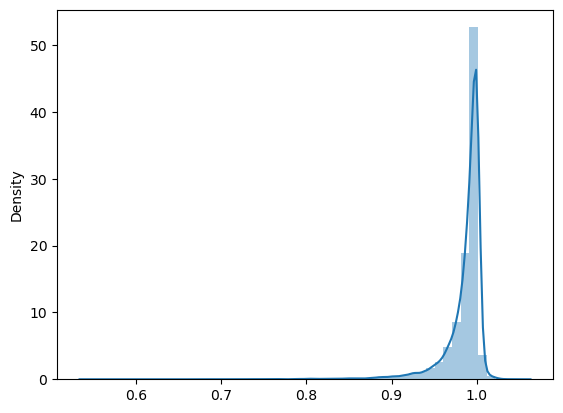

In [183]:
sns.distplot(preds_ranker)



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot:xlabel='rank', ylabel='Density'>

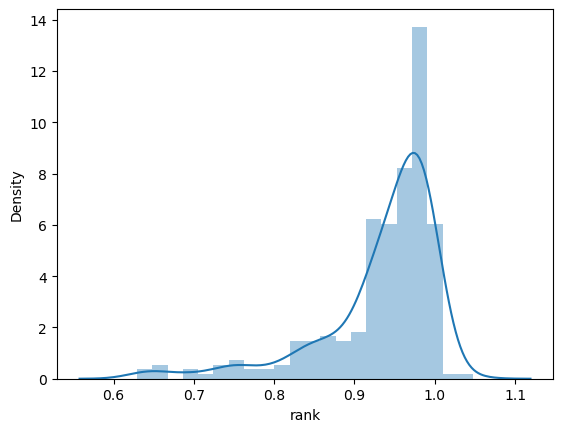

In [196]:
sns.distplot(df_val[df_val['rnp'] == False]['rank'])

In [185]:
df_val['rank'] = preds_ranker


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [186]:
df_val = df_val.sort_values('rank', ascending=False)

In [195]:
df_val[df_val['rank'] > 1.01][['is_termination', 'win_qty_44fz', 'procedure_qty_44fz']].describe()

,is_termination,win_qty_44fz,procedure_qty_44fz
count,166.000000,166.000000,166.000000
mean,25.975904,91.668675,127.150602
std,112.371190,279.092716,299.006022
min,0.000000,0.000000,0.000000
25%,0.000000,7.250000,9.250000
50%,1.000000,31.500000,41.500000
75%,17.000000,84.500000,129.250000
max,1249.000000,3092.000000,3092.000000


In [189]:
df_val[df_val['rank'] < 1][['is_termination', 'win_qty_44fz', 'procedure_qty_44fz']].describe()

,is_termination,win_qty_44fz,procedure_qty_44fz
count,14517.000000,14517.000000,14517.000000
mean,1.851347,10.600882,24.575188
std,13.494453,78.994081,112.672165
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,0.000000,3.000000,5.000000
75%,1.000000,7.000000,17.000000
max,568.000000,7066.000000,7067.000000


In [182]:
eval_tsv = pd.read_csv('/kaggle/working/RMSE/test_error.tsv', sep='\t')
eval_tsv

,iter,RMSE,PrecisionAt:top=1,RecallAt:top=1,MAP:top=10
0,0,0.118768,0.985649,1,0.985649
1,5,0.118113,0.985649,1,0.985649
2,10,0.117707,0.985649,1,0.985649
3,15,0.117399,0.985649,1,0.985649
4,20,0.117205,0.985649,1,0.985649
...,...,...,...,...,...
196,980,0.115448,0.985649,1,0.985649
197,985,0.115452,0.985649,1,0.985649
198,990,0.115448,0.985649,1,0.985649
199,995,0.115448,0.985649,1,0.985649


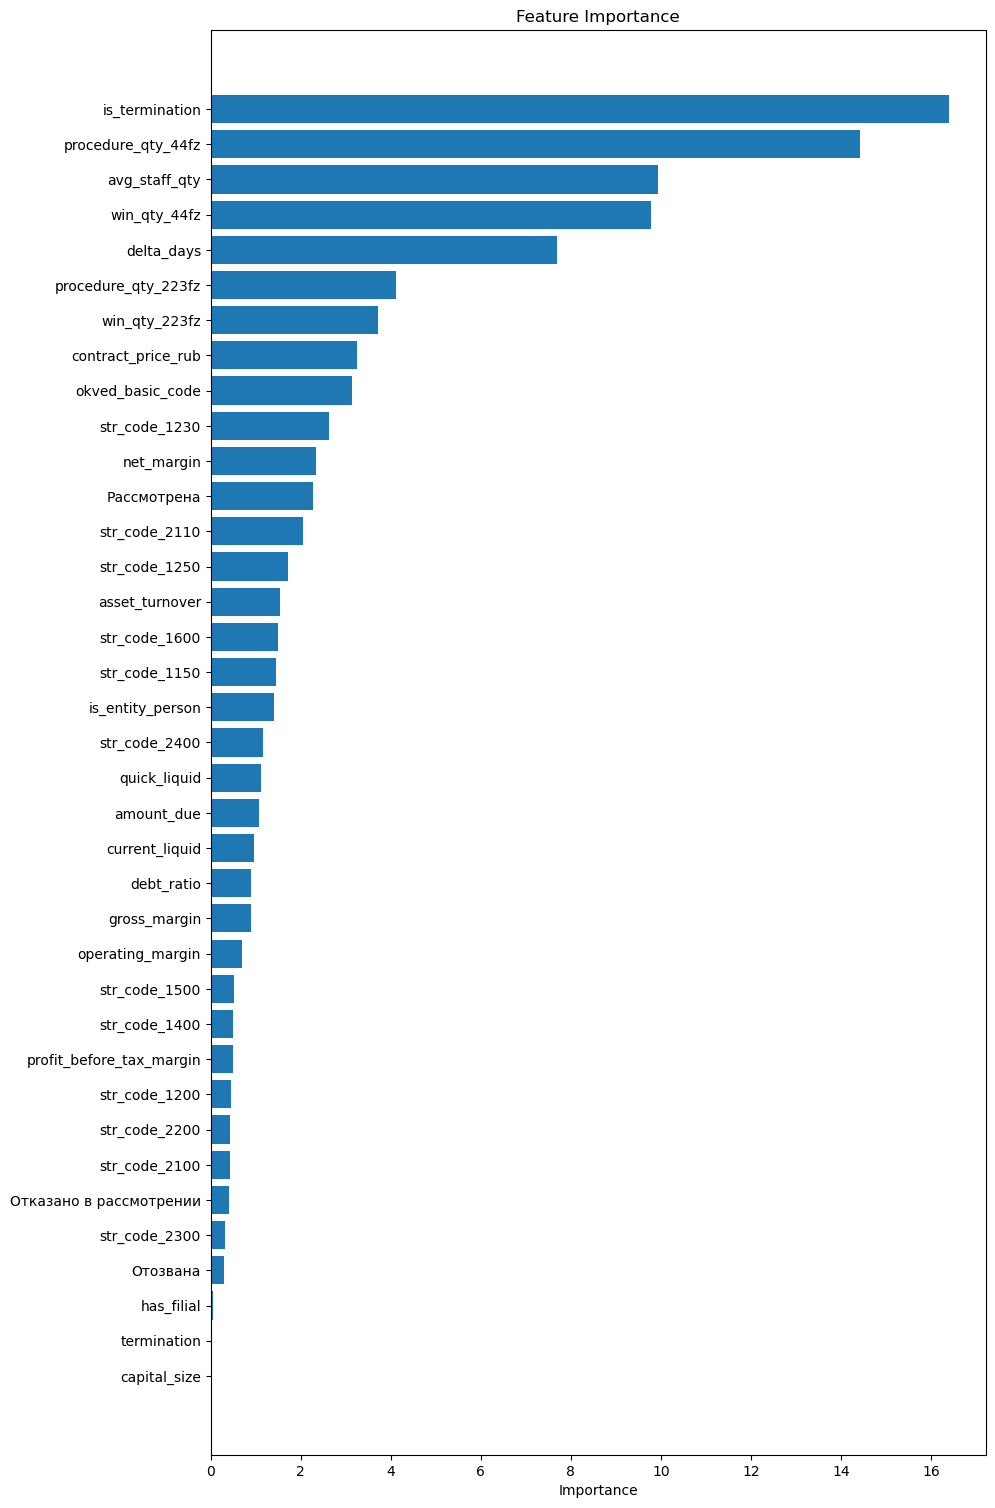

In [184]:
import matplotlib.pyplot as plt

feature_importance = model_ranker.get_feature_importance()
feature_names = df_train.drop(columns=['rnp', 'real_rnp', 'id_contract', 'inn']).columns
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, len(feature_importance) * 0.5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

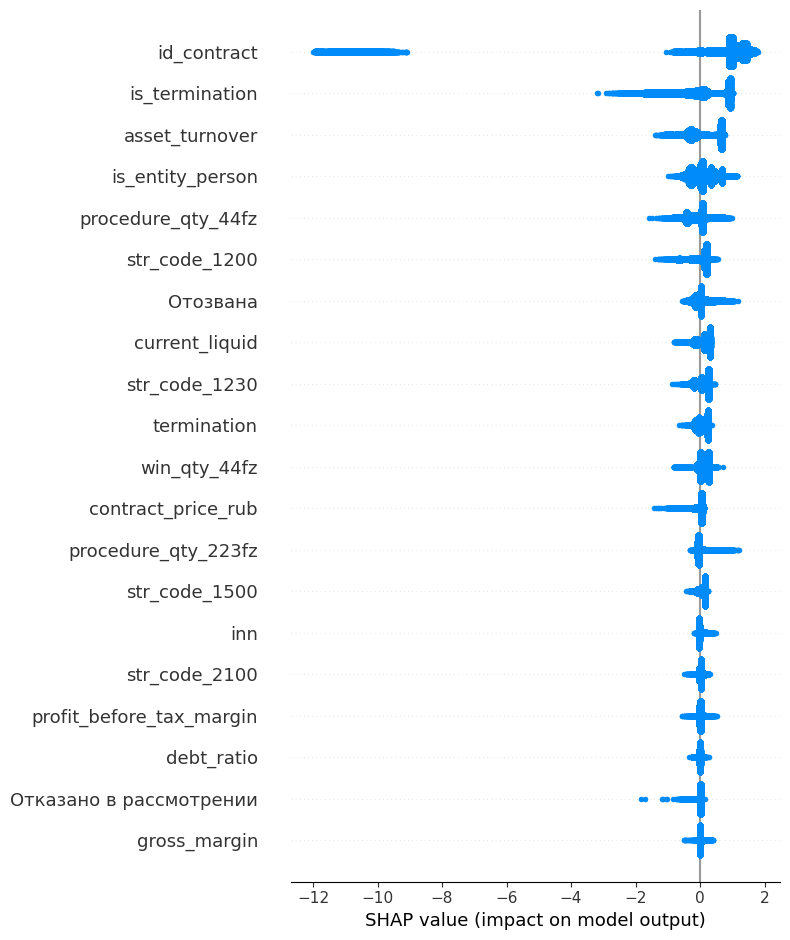

In [90]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train)

shap.summary_plot(shap_values, df_train.drop(columns=['rnp', 'real_rnp']).columns)